### 01. load and preprocess data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train['date'] = train['date'].apply(lambda i: i[2:6]).astype(int)  # int로 변경
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,1410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,1502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,1502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,1406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,1501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot' 'long' 'sqft_lot15' 'id' 'condition'
 'zipcode' 'date']


<AxesSubplot:>

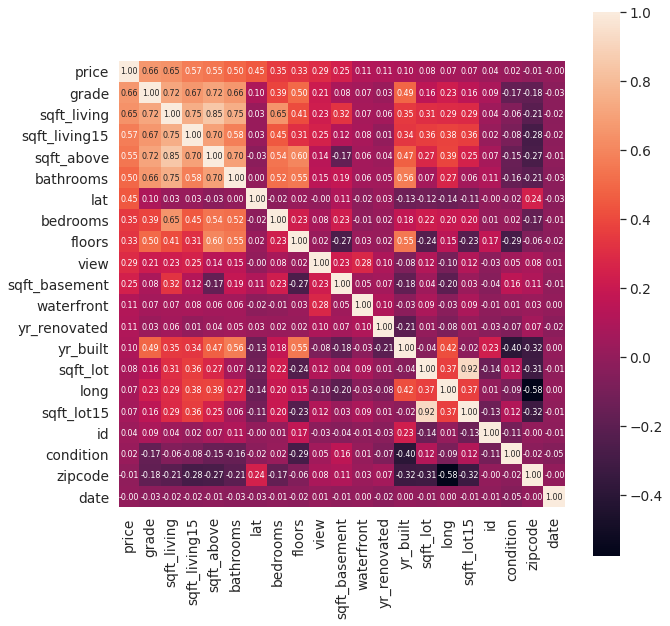

In [5]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21,columns='price').index # 상위 10개 지정
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [6]:
train.zipcode[:10]

0    98178
1    98028
2    98074
3    98003
4    98198
5    98007
6    98115
7    98028
8    98074
9    98107
Name: zipcode, dtype: int64

In [7]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [9]:
train.describe()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15035.000000,15035.000000,15035.000000,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000,15035.000000
mean,1438.545993,3.369139,2.115065,2083.790223,1.529697e+04,1.498071,0.007117,0.234253,3.406651,7.660725,1794.158164,289.632059,1971.100432,83.798936,98078.031726,47.560721,-122.213677,1992.754772,12823.884935
std,44.252050,0.902721,0.767519,922.134087,4.261282e+04,0.538522,0.084063,0.763376,0.646505,1.179803,831.738609,440.663284,29.407612,400.398498,53.297815,0.138164,0.141294,691.456442,27736.259787
min,1405.000000,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,1407.000000,3.000000,1.750000,1430.000000,5.027500e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.472700,-122.328000,1490.000000,5100.000000
50%,1410.000000,3.000000,2.250000,1910.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1570.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.231000,1850.000000,7610.000000
75%,1502.000000,4.000000,2.500000,2560.000000,1.069550e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2230.000000,550.000000,1997.000000,0.000000,98117.000000,47.678300,-122.126000,2360.000000,10076.000000
max,1505.000000,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [10]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [11]:
test['date'] = test['date'].apply(lambda i: i[2:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [12]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

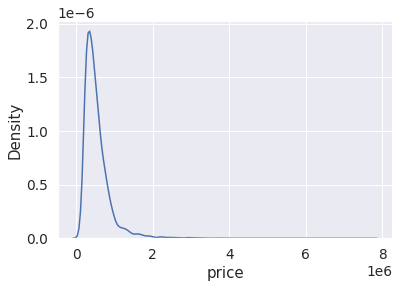

In [13]:
sns.kdeplot(y)
plt.show()

In [14]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

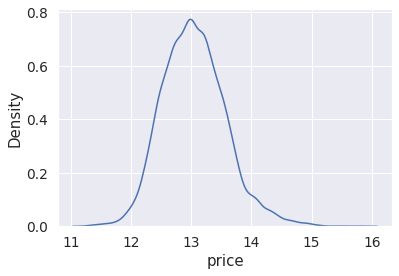

In [15]:
sns.kdeplot(y)
plt.show()

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [18]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))  # np.expml : 원래 스케일로 되돌리기

In [19]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [20]:
random_state=1028

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [22]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 124131.19692815996,
 'XGBRegressor': 106615.63530702426,
 'LGBMRegressor': 107257.79913572696,
 'RandomForestRegressor': 134623.62574778864}

In [23]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,134623.625748
GradientBoostingRegressor,124131.196928
LGBMRegressor,107257.799136
XGBRegressor,106615.635307


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 11], 
    'gamma': [0.5, 0.7, 0.3],
    'learning_rate': [0.029, 0.03],
    'boosting':["gbdt"],
    'num_iteration': [2500, 3000],
    "num_leaves" :[18, 19, 20],
    "objective" : ["regression"],
    "bagging_freq":[1],
    "bagging_fraction":[0.7, 0.8, 0.9]
}

In [25]:
model = LGBMRegressor(random_state=random_state)
# model = XGBRegressor(random_state=random_state)

In [26]:

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 10.0min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed: 23.0min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed: 41.3min
[Parallel(n_jobs=5)]: Done 1080 out of 1080 | elapsed: 56.5min finished


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] num_iterations is set=2500, num_iteration=2500 will be ignored. Current value: num_iterations=2500
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=1028), n_jobs=5,
             param_grid={'bagging_fraction': [0.7, 0.8, 0.9],
                         'bagging_freq': [1], 'boosting': ['gbdt'],
                         'gamma': [0.5, 0.7, 0.3],
                         'learning_rate': [0.029, 0.03], 'max_depth': [10, 11],
                         'n_estimators': [100], 'num_iteration': [2500, 3000],
                         'num_leaves': [18, 19, 20],
                         'objective': ['regression']},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
import sklearn
sklearn. __version__

'0.23.0'

In [28]:
grid_model.cv_results_

{'mean_fit_time': array([12.45055285, 12.82445197, 13.39688134, 14.44913478, 15.4830327 ,
        15.07937155, 12.5288868 , 13.37877402, 13.38842092, 14.83106146,
        15.57754655, 16.22409544, 12.74412603, 11.87893353, 13.21309652,
        14.87369294, 16.10164819, 15.86077824, 12.53938866, 12.38051419,
        13.69079981, 15.15671144, 15.25036492, 15.44930863, 12.58461127,
        12.79945316, 13.52883792, 15.00904565, 14.65369692, 15.53887892,
        13.10301514, 13.06687136, 13.31331248, 14.98654552, 14.83426118,
        15.82917686, 12.92733207, 12.36694717, 12.96824827, 15.7285233 ,
        14.8953548 , 15.31826959, 12.82677774, 12.79140124, 13.67902517,
        14.81763716, 14.99771805, 15.75653687, 12.94989924, 12.48110008,
        12.97753253, 14.94120836, 15.18238645, 16.15662622, 12.47650523,
        12.51783371, 13.76370916, 13.98728876, 15.51717119, 16.14693308,
        12.80452681, 13.32558317, 13.36595898, 14.1222455 , 15.33243551,
        15.81517301, 12.56864915, 

In [29]:
params = grid_model.cv_results_['params']
params

[{'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 2500,
  'num_leaves': 18,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 2500,
  'num_leaves': 19,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 2500,
  'num_leaves': 20,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5,
  'learning_rate': 0.029,
  'max_depth': 10,
  'n_estimators': 100,
  'num_iteration': 3000,
  'num_leaves': 18,
  'objective': 'regression'},
 {'bagging_fraction': 0.7,
  'bagging_freq': 1,
  'boosting': 'gbdt',
  'gamma': 0.5

In [30]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02556187, -0.02553471, -0.02562671, -0.02569318, -0.02563172,
       -0.02573317, -0.02555029, -0.02555362, -0.02559161, -0.02565518,
       -0.02569174, -0.0257253 , -0.02548184, -0.02569079, -0.02562751,
       -0.02561452, -0.02582274, -0.02574161, -0.02542846, -0.02572903,
       -0.02563398, -0.02555656, -0.02585544, -0.02576457, -0.02556187,
       -0.02553471, -0.02562671, -0.02569318, -0.02563172, -0.02573317,
       -0.02555029, -0.02555362, -0.02559161, -0.02565518, -0.02569174,
       -0.0257253 , -0.02548184, -0.02569079, -0.02562751, -0.02561452,
       -0.02582274, -0.02574161, -0.02542846, -0.02572903, -0.02563398,
       -0.02555656, -0.02585544, -0.02576457, -0.02556187, -0.02553471,
       -0.02562671, -0.02569318, -0.02563172, -0.02573317, -0.02555029,
       -0.02555362, -0.02559161, -0.02565518, -0.02569174, -0.0257253 ,
       -0.02548184, -0.02569079, -0.02562751, -0.02561452, -0.02582274,
       -0.02574161, -0.02542846, -0.02572903, -0.02563398, -0.02

In [31]:
results = pd.DataFrame(params)
results['score'] = score

results

,bagging_fraction,bagging_freq,boosting,gamma,learning_rate,max_depth,n_estimators,num_iteration,num_leaves,objective,score
0,0.7,1,gbdt,0.5,0.029,10,100,2500,18,regression,-0.025562
1,0.7,1,gbdt,0.5,0.029,10,100,2500,19,regression,-0.025535
2,0.7,1,gbdt,0.5,0.029,10,100,2500,20,regression,-0.025627
3,0.7,1,gbdt,0.5,0.029,10,100,3000,18,regression,-0.025693
4,0.7,1,gbdt,0.5,0.029,10,100,3000,19,regression,-0.025632
...,...,...,...,...,...,...,...,...,...,...,...
211,0.9,1,gbdt,0.3,0.030,11,100,2500,19,regression,-0.025479
212,0.9,1,gbdt,0.3,0.030,11,100,2500,20,regression,-0.025492
213,0.9,1,gbdt,0.3,0.030,11,100,3000,18,regression,-0.025554
214,0.9,1,gbdt,0.3,0.030,11,100,3000,19,regression,-0.025585


In [32]:
grid_model.best_params_

{'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'boosting': 'gbdt',
 'gamma': 0.5,
 'learning_rate': 0.029,
 'max_depth': 11,
 'n_estimators': 100,
 'num_iteration': 2500,
 'num_leaves': 20,
 'objective': 'regression'}

In [33]:
results['RMSLE'] = np.sqrt(-1 * results['score'])
results

,bagging_fraction,bagging_freq,boosting,gamma,learning_rate,max_depth,n_estimators,num_iteration,num_leaves,objective,score,RMSLE
0,0.7,1,gbdt,0.5,0.029,10,100,2500,18,regression,-0.025562,0.159881
1,0.7,1,gbdt,0.5,0.029,10,100,2500,19,regression,-0.025535,0.159796
2,0.7,1,gbdt,0.5,0.029,10,100,2500,20,regression,-0.025627,0.160083
3,0.7,1,gbdt,0.5,0.029,10,100,3000,18,regression,-0.025693,0.160291
4,0.7,1,gbdt,0.5,0.029,10,100,3000,19,regression,-0.025632,0.160099
...,...,...,...,...,...,...,...,...,...,...,...,...
211,0.9,1,gbdt,0.3,0.030,11,100,2500,19,regression,-0.025479,0.159621
212,0.9,1,gbdt,0.3,0.030,11,100,2500,20,regression,-0.025492,0.159661
213,0.9,1,gbdt,0.3,0.030,11,100,3000,18,regression,-0.025554,0.159857
214,0.9,1,gbdt,0.3,0.030,11,100,3000,19,regression,-0.025585,0.159954


In [34]:
results = results.sort_values('RMSLE')
results[:10]

,bagging_fraction,bagging_freq,boosting,gamma,learning_rate,max_depth,n_estimators,num_iteration,num_leaves,objective,score,RMSLE
176,0.9,1,gbdt,0.7,0.029,11,100,2500,20,regression,-0.025427,0.159458
152,0.9,1,gbdt,0.5,0.029,11,100,2500,20,regression,-0.025427,0.159458
200,0.9,1,gbdt,0.3,0.029,11,100,2500,20,regression,-0.025427,0.159458
66,0.7,1,gbdt,0.3,0.030,11,100,2500,18,regression,-0.025428,0.159463
42,0.7,1,gbdt,0.7,0.030,11,100,2500,18,regression,-0.025428,0.159463
18,0.7,1,gbdt,0.5,0.030,11,100,2500,18,regression,-0.025428,0.159463
158,0.9,1,gbdt,0.5,0.030,10,100,2500,20,regression,-0.025450,0.159531
182,0.9,1,gbdt,0.7,0.030,10,100,2500,20,regression,-0.025450,0.159531
206,0.9,1,gbdt,0.3,0.030,10,100,2500,20,regression,-0.025450,0.159531
193,0.9,1,gbdt,0.3,0.029,10,100,2500,19,regression,-0.025453,0.159540


In [35]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [48]:
model = LGBMRegressor(random_state=random_state, n_estimators=100,
    max_depth=11, 
    gamma=0.7,
    learning_rate=0.029,
    boosting="gbdt",
    num_iteration=2500,
    objective="regression",
    num_leaves=20,
     bagging_freq=1,
    bagging_fraction=0.9)



In [38]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [52]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.160072')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160072.csv


In [53]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [55]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.159458')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.159458.csv saved!


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [ ]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### feature 와 price의 상관관계속에서 연관성이 작은 feature를 삭제

In [ ]:
import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=21,columns='price').index # 상위 10개 지정
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [ ]:
train.zipcode[:10]

In [ ]:
y = train['price']
del train['price']

print(train.columns)

In [ ]:
del train['id']
print(train.columns)

In [ ]:
train.describe()

In [ ]:
test.head()

In [ ]:
test['date'] = test['date'].apply(lambda i: i[2:6]).astype(int)

del test['id']

print(test.columns)

In [ ]:
y

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

In [ ]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [ ]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('얍💢')

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [ ]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))) 

In [ ]:
random_state=1028

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
gboost.__class__.__name__

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [ ]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

In [ ]:
get_cv_score(models)

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

In [ ]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

### 느낀점 